In [91]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import networkx as nx
from sklearn.preprocessing import StandardScaler
from semopy import semplot, calc_stats, Model
from IPython.display import Image

In [92]:
token_ids = {
    # Ongoing government shutdown
    "gov_shutdown_545": "7045107161367241233811523851106536676632348173555291268726302515224841822187",
    "gov_shutdown_763": "33863269898549252781275803678269200480782857182444175052616333799704258288948",
    "gov_shutdown_day": "63180324456084138896964901136480196139788004854700828798087417260562751585462",

    # Mixed macro picture
    "us_recession_2025": "104173557214744537570424345347209544585775842950109756851652855913015295701992",
    "fed_decisions_2025": "108483415714976290361271305280593264746125309611707698966906198707902268429606",
    "fed_decision_dec": "74018646712472971445258547247048869505144598783748525202442089895996249694683",

    # Sharp correction / AI sentiments
    "msft_price_nov25": "79366712640783192549004431572690423518507052197194852154324444873305516668498",
    "nvda_above_nov25": "20085731581751529026511534316101049820474111178674214083357775723904061557804",
    "nvda_above_nov14": "39581886549841090880905509315698538101325593642747204027615683331702494803428",
    "nvda_price_nov2025": "82867428501881085189484820117679815591951852048433338506125379110423550930197",

    # Global trade negotiations
    "trade_deals_2025": "5387225204087783518802178465274078547261862932574892838425263565124999003543",
    "trump_trade_before2027": "15956716365476211612502136275144529677999675468726683505087289708083638299709",
    "tariff_agreements_by_nov30": "21783243248036167372014169285747818472150510054656233937795397515654120166239"
}


In [93]:
def fetch_polymarket_prices(clob_token_id, interval="max"):
    url = f"https://clob.polymarket.com/prices-history?market={clob_token_id}&interval={interval}"
    r = requests.get(url, timeout=30)
    r.raise_for_status()
    j = r.json()
    data = j.get("history", [])
    if not data:
        return pd.DataFrame(columns=["date", "price"])
    df = pd.DataFrame(data)
    df["date"] = pd.to_datetime(df["t"], unit="s").dt.date
    df = df.groupby("date")["p"].mean().reset_index().rename(columns={"p": "price"})
    return df

def get_btc_data(days):
    url = f"https://api.coingecko.com/api/v3/coins/bitcoin/market_chart?vs_currency=usd&days={days}"
    r = requests.get(url)
    data = r.json()
    prices = pd.DataFrame(data["prices"], columns=["ts", "btc_price"])
    vols   = pd.DataFrame(data["total_volumes"], columns=["ts", "btc_volume"])
    mcap   = pd.DataFrame(data["market_caps"], columns=["ts", "btc_mcap"])
    df = prices.merge(vols, on="ts").merge(mcap, on="ts")
    df["date"] = pd.to_datetime(df["ts"], unit="ms").dt.date
    df = df[["date", "btc_price", "btc_volume", "btc_mcap"]]
    df_daily = (df.groupby("date").agg(btc_price=("btc_price", "mean"),btc_volume=("btc_volume", "sum"),btc_mcap=("btc_mcap", "mean"),).reset_index())
    return df_daily

btc = get_btc_data(31)
btc.head()


,date,btc_price,btc_volume,btc_mcap
0,2025-10-12,113488.848258,1.051411e+12,2.261380e+12
1,2025-10-13,115107.766052,2.144611e+12,2.294415e+12
2,2025-10-14,112669.953477,1.842933e+12,2.245612e+12
3,2025-10-15,111939.730120,1.937868e+12,2.231351e+12
4,2025-10-16,110224.355349,1.738250e+12,2.197420e+12


In [94]:
dfs = {}
for name, tid in token_ids.items():
    df = fetch_polymarket_prices(tid, interval="max")
    dfs[name] = df.rename(columns={"price": name})
df_merged = None
for name, d in dfs.items():
    if df_merged is None:
        df_merged = d.copy()
    else:
        df_merged = pd.merge(df_merged, d, on="date", how="outer")

btc = get_btc_data(31)
df_merged = pd.merge(df_merged, btc, on="date", how="outer")
df_merged["date"] = pd.to_datetime(df_merged["date"], errors="coerce")
df_merged = df_merged.sort_values("date").reset_index(drop=True)
df_merged = df_merged.set_index("date")
numeric_cols = df_merged.select_dtypes(include=["number"]).columns
df_merged[numeric_cols] = df_merged[numeric_cols].interpolate(method="time").ffill().bfill()
df_merged = df_merged.reset_index()
print(df_merged.shape)
display(df_merged.head())


(32, 17)


,date,gov_shutdown_545,gov_shutdown_763,gov_shutdown_day,us_recession_2025,fed_decisions_2025,fed_decision_dec,msft_price_nov25,nvda_above_nov25,nvda_above_nov14,nvda_price_nov2025,trade_deals_2025,trump_trade_before2027,tariff_agreements_by_nov30,btc_price,btc_volume,btc_mcap
0,2025-10-12,0.061159,0.632692,0.069485,0.058476,0.699512,0.065000,0.5,0.4984,0.500625,0.5,0.088128,0.5325,0.5,113488.848258,1.051411e+12,2.261380e+12
1,2025-10-13,0.061250,0.632692,0.069485,0.055000,0.695000,0.067118,0.5,0.4984,0.500625,0.5,0.085719,0.5325,0.5,115107.766052,2.144611e+12,2.294415e+12
2,2025-10-14,0.071979,0.632692,0.069485,0.055000,0.731007,0.061840,0.5,0.4984,0.500625,0.5,0.087056,0.5325,0.5,112669.953477,1.842933e+12,2.245612e+12
3,2025-10-15,0.080972,0.632692,0.069485,0.055000,0.781806,0.048819,0.5,0.4984,0.500625,0.5,0.091719,0.5325,0.5,111939.730120,1.937868e+12,2.231351e+12
4,2025-10-16,0.075000,0.632692,0.069485,0.055799,0.793611,0.050000,0.5,0.4984,0.500625,0.5,0.101743,0.5325,0.5,110224.355349,1.738250e+12,2.197420e+12


In [95]:
observed_vars = list(dfs.keys()) + ["btc_price"]
print("Using observed vars:", observed_vars)

df_sem = df_merged.copy()
df_sem[observed_vars] = df_sem[observed_vars] * 100  

df_sem = df_sem.dropna(subset=observed_vars, how="all") 
df_sem[observed_vars] = df_sem[observed_vars].ffill().bfill()

constant_cols = [c for c in observed_vars if df_sem[c].nunique() <= 1]
if constant_cols:
    print("⚠️ Dropping constant columns:", constant_cols)
    df_sem = df_sem.drop(columns=constant_cols)
    observed_vars = [c for c in observed_vars if c not in constant_cols]

X = df_sem[observed_vars].astype(float)
scaler = StandardScaler()
X_std = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

print(X_std.shape)
display(X_std.head())


Using observed vars: ['gov_shutdown_545', 'gov_shutdown_763', 'gov_shutdown_day', 'us_recession_2025', 'fed_decisions_2025', 'fed_decision_dec', 'msft_price_nov25', 'nvda_above_nov25', 'nvda_above_nov14', 'nvda_price_nov2025', 'trade_deals_2025', 'trump_trade_before2027', 'tariff_agreements_by_nov30', 'btc_price']
(32, 14)


,gov_shutdown_545,gov_shutdown_763,gov_shutdown_day,us_recession_2025,fed_decisions_2025,fed_decision_dec,msft_price_nov25,nvda_above_nov25,nvda_above_nov14,nvda_price_nov2025,trade_deals_2025,trump_trade_before2027,tariff_agreements_by_nov30,btc_price
0,-0.663929,-1.756723,0.257769,1.549228,-0.992877,0.968489,0.802991,-0.614232,0.609581,0.802238,0.241084,0.497344,0.445071,1.229581
1,-0.663538,-1.756723,0.257769,1.082977,-1.049865,1.064401,0.802991,-0.614232,0.609581,0.802238,0.178478,0.497344,0.445071,1.638900
2,-0.617764,-1.756723,0.257769,1.082977,-0.595103,0.825407,0.802991,-0.614232,0.609581,0.802238,0.213215,0.497344,0.445071,1.022536
3,-0.579397,-1.756723,0.257769,1.082977,0.046475,0.235785,0.802991,-0.614232,0.609581,0.802238,0.334389,0.497344,0.445071,0.837910
4,-0.604876,-1.756723,0.257769,1.190110,0.195577,0.289244,0.802991,-0.614232,0.609581,0.802238,0.594873,0.497344,0.445071,0.404203


In [96]:
model_desc = """
us_recession_2025 ~~ fed_decisions_2025
gov_shutdown_545   ~ us_recession_2025 + fed_decisions_2025
gov_shutdown_763   ~ us_recession_2025 + fed_decisions_2025
gov_shutdown_day   ~ gov_shutdown_545 + gov_shutdown_763 + us_recession_2025
nvda_price_nov2025 ~ us_recession_2025 + fed_decisions_2025 + gov_shutdown_545 + gov_shutdown_day
nvda_above_nov25   ~ nvda_price_nov2025
nvda_above_nov14   ~ nvda_price_nov2025
msft_price_nov25   ~ nvda_price_nov2025 + us_recession_2025
trade_deals_2025   ~ gov_shutdown_545 + fed_decisions_2025
tariff_agreements_by_nov30 ~ trade_deals_2025
trump_trade_before2027 ~ trade_deals_2025 + tariff_agreements_by_nov30
gov_shutdown_545 ~~ gov_shutdown_763
trade_deals_2025 ~~ tariff_agreements_by_nov30

btc_price ~ nvda_price_nov2025 + msft_price_nov25 + fed_decisions_2025 + us_recession_2025
"""
print("Columns in X_std:", list(X_std.columns))

Columns in X_std: ['gov_shutdown_545', 'gov_shutdown_763', 'gov_shutdown_day', 'us_recession_2025', 'fed_decisions_2025', 'fed_decision_dec', 'msft_price_nov25', 'nvda_above_nov25', 'nvda_above_nov14', 'nvda_price_nov2025', 'trade_deals_2025', 'trump_trade_before2027', 'tariff_agreements_by_nov30', 'btc_price']



Path coefficients:


,lval,op,rval,Estimate,p-value
0,gov_shutdown_545,~,us_recession_2025,-0.483546,4.494027e-03
1,gov_shutdown_545,~,fed_decisions_2025,-0.107928,5.259745e-01
2,gov_shutdown_763,~,us_recession_2025,-0.898626,9.814372e-14
3,gov_shutdown_763,~,fed_decisions_2025,0.258782,3.207165e-02
4,gov_shutdown_day,~,gov_shutdown_545,-0.999362,5.950795e-14
5,gov_shutdown_day,~,gov_shutdown_763,0.130673,4.591688e-01
6,gov_shutdown_day,~,us_recession_2025,-0.173203,2.455719e-01
7,nvda_price_nov2025,~,us_recession_2025,0.407156,1.305246e-04
8,nvda_price_nov2025,~,fed_decisions_2025,0.356923,6.896013e-05
9,nvda_price_nov2025,~,gov_shutdown_545,-0.509518,1.851220e-03


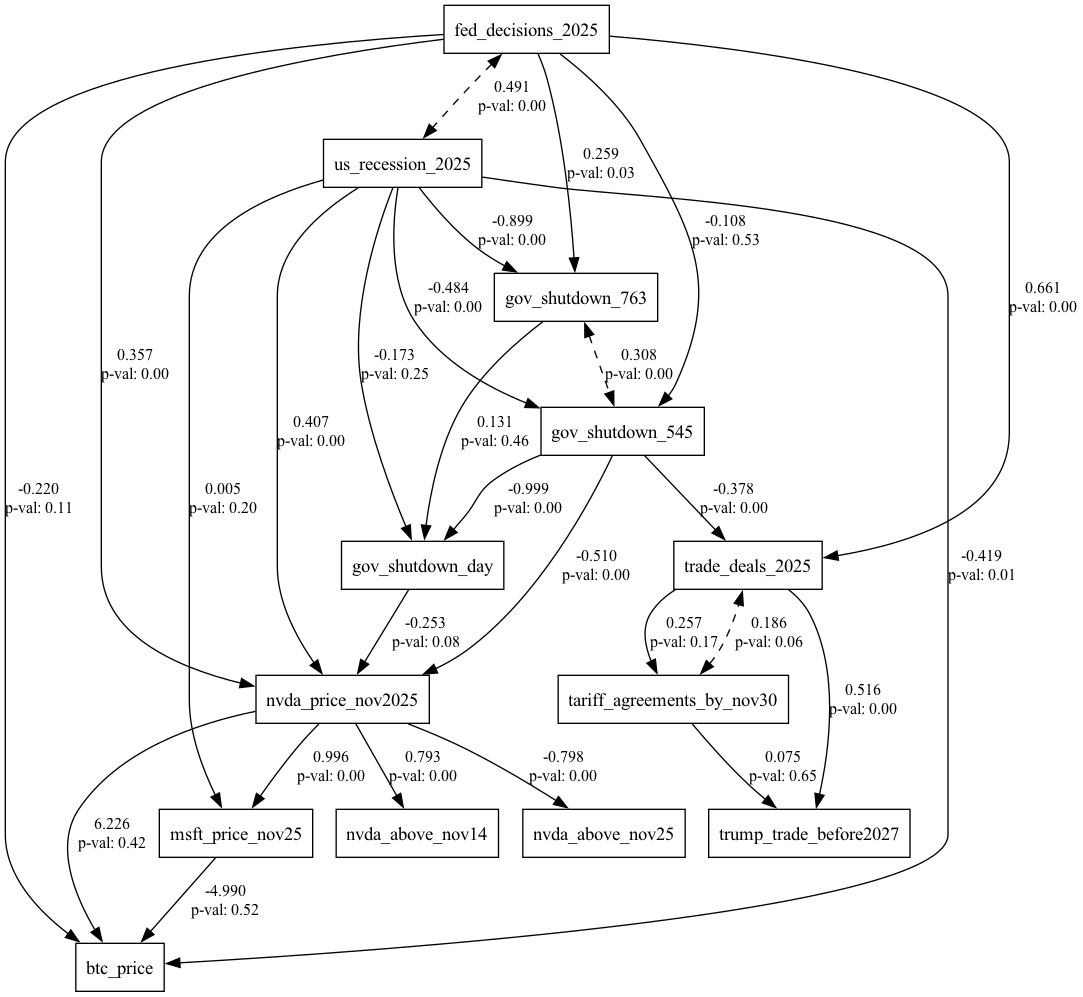


Interpretation tips:
- Coeff signs (positive/negative) indicate direction of the influence.
- Magnitude: standardized estimates (if you standardized) show relative strength.
- p-values and SE tell you if a path is statistically different from zero.
- Use modification indices (semopy can compute) to suggest missing paths, but treat with care.


In [97]:
model = Model(model_desc)
model.fit(X_std)
stats = calc_stats(model)
print("\nPath coefficients:")
params = model.inspect() 

cols_to_show = [c for c in ['lval', 'op', 'rval', 'Estimate', 'SE', 'p-value'] if c in params.columns]
display(params[cols_to_show])

semplot(model, "sem_model_graph.png", plot_covs=True)
display(Image(filename="sem_model_graph.png"))
print("\nInterpretation tips:")
print("- Coeff signs (positive/negative) indicate direction of the influence.")
print("- Magnitude: standardized estimates (if you standardized) show relative strength.")
print("- p-values and SE tell you if a path is statistically different from zero.")
print("- Use modification indices (semopy can compute) to suggest missing paths, but treat with care.")